In [17]:
from pydantic_ai import Agent
from pydantic_graph import BaseNode, GraphRunContext, End, Graph
from pydantic_ai.providers.google_gla import GoogleGLAProvider
from pydantic_ai.models.gemini import GeminiModel
from dotenv import load_dotenv
import os
from pydantic import Field
from typing import  List, Dict, Optional
from dataclasses import dataclass
from IPython.display import Image, display
load_dotenv()

google_api_key=os.getenv('google_api_key')


In [7]:
llm=GeminiModel('gemini-2.0-flash', provider=GoogleGLAProvider(api_key=google_api_key))

In [4]:
@dataclass
class State:
    research: str
    presentation_plan: List[Dict]
    images: List[Dict]
    presentation: Dict

In [9]:
@dataclass
class image:
    image_description: str = Field(description='the image description')
    image_title: str = Field(description='the image title')
    image_position: int = Field(description='the image position in the presentation')

@dataclass
class text:
    Text_description: str = Field(description='the text description')
    Text_title: str = Field(description='the text title')
    Text_position: int = Field(description='the text position in the presentation')

@dataclass
class steps:
    step: str = Field(description='the step to complete, either image_gen or get_text')
    image_data: Optional[image] = Field(description='the image to be displayed in the step')
    text_data: Optional[text] = Field(description='the text to be displayed in the step')

@dataclass
class Presentation_plan:
    tasks: list[steps] = Field(description='the steps to complete')

In [8]:
presentation_plan_agent=Agent(llm, result_type=Presentation_plan, system_prompt='generate a presentation plan based on the research')

In [13]:
class Presentation_plan_node(BaseNode[State]):
    async def run(self, ctx: GraphRunContext[State])->End:
        prompt=f'generate a presentation plan based on the research: {ctx.state.research}'
        result=await presentation_plan_agent.run(prompt)
        ctx.state.presentation_plan=result.data.tasks
        return step_execution_node()

In [11]:
class should_continue_node(BaseNode[State]):
    async def run(self, ctx: GraphRunContext[State])->End:
        if ctx.state.presentation_plan.tasks:
            return step_execution_node()
        else:
            return End()
            


In [10]:
class step_execution_node(BaseNode[State]):
    async def run(self, ctx: GraphRunContext[State])->End:
        if ctx.state.presentation_plan.tasks[0].step=='image_gen':
            image_data={
                        'image_title':ctx.state.presentation_plan.tasks[0].image_data.image_title, 
                        'image_url':'example_image_url'}
            ctx.state.images.append(image_data)
            ctx.state.presentation_plan.tasks.pop(0)
            return should_continue_node()
        elif ctx.state.presentation_plan.tasks[0].step=='get_text':
            text_data={
                        'text_title':ctx.state.presentation_plan.tasks[0].text_data.text_title, 
                        'text_content':'example_text_content'}  
            ctx.state.texts.append(text_data)
            ctx.state.presentation_plan.tasks.pop(0)
            return should_continue_node()

In [18]:
class Presentation_gen:
    def __init__(self):
        self.graph=Graph(nodes=[Presentation_plan_node, should_continue_node, step_execution_node])
        self.state=State(research='', presentation_plan=[], images=[], presentation={})

    async def chat(self,research:str):
        """Chat with the deep research engine,
        Args:
            query (str): The query to search for
        Returns:
            str: The response from the deep research engine
        """
        self.state.research=research
        response=await self.graph.run(Presentation_plan_node(),state=self.state)
        return response.output


    def display_graph(self):
        """Display the graph of the deep research engine
        Returns:
            Image: The image of the graph
        """
        image=self.graph.mermaid_image()
        return display(Image(image))

In [15]:
prs=Presentation_gen()


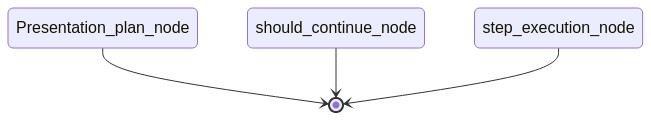

In [19]:
prs.display_graph()